### Постановка задачи

Требуется на основании демографических данных о клиентах банка, истории их платежей и состоянии счета, предсказать невыполнение их обязательств по кредитной карте в следующем месяце.

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [2]:
import numpy as np
import pandas as pd
import re

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
np.warnings.filterwarnings('ignore')

C:\Users\alex0\Anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\alex0\Anaconda\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### Функции

In [3]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [4]:
# Приведение к числовому типу признака "Purpose"
def purpose_to_num(purpose):
    result_array = []
    for i in purpose:
        if i == "debt consolidation":
            result_array.append(0)
        elif i == "other":
            result_array.append(1)
        elif i == "home improvements":
            result_array.append(2)
        elif i == "take a trip":
            result_array.append(3)
        elif i == "buy a car":
            result_array.append(4)
        elif i == "small business":
            result_array.append(5)
        elif i == "business loan":
            result_array.append(6)
        elif i == "wedding":
            result_array.append(7)
        elif i == "educational expenses":
            result_array.append(8)
        elif i == "buy house":
            result_array.append(9)
        elif i == "medical bills":
            result_array.append(10)
        elif i == "moving":
            result_array.append(11)
        elif i == "major purchase":
            result_array.append(12)
        elif i == "vacation":
            result_array.append(13)
        else:
            result_array.append(15)
    return result_array

In [5]:
# Приведение к int типу поля "Years in current job"
def years_in_job_to_num(years_in_job):
    result_array = []
    for i in years_in_job:
        if type(i) is str:
            temp = int(re.search(r'\d+', i).group())
            result_array.append(temp)
        else:
            result_array.append(i)
    return result_array

In [6]:
# Приведение к числовому типу признака "Term"
def term_to_num(term):
    result_array = []
    for i in term:
        if i == "Short Term":
            result_array.append(0)
        else:
            result_array.append(1)
    return result_array

In [7]:
# Приведение к числовому типу признака "Home Ownership"
def home_ownership_to_num(home_ownership):
    result_array = []
    for i in home_ownership:
        if i == "Own Home":
            result_array.append(0)
        elif i == "Home Mortgage":
            result_array.append(1)
        elif i == "Rent":
            result_array.append(2)
        else:
            result_array.append(3)
    return result_array

In [8]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [9]:
def objects_to_num(df):
    res_df = df
    res_df['Term'] = term_to_num(res_df['Term'])
    res_df['Years in current job'] = years_in_job_to_num(res_df['Years in current job'])
    res_df['Home Ownership'] = home_ownership_to_num(res_df['Home Ownership'])
    res_df['Purpose'] = purpose_to_num(res_df['Purpose'])
    return res_df

In [10]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [11]:
def fix_nans(df, features):
    for i in features:
        df.loc[df[i].isnull(), i] = df[i].mode()[0]
    return df

**Пути к директориям и файлам**

In [12]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

### Загрузка данных

In [13]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

### Обзор данных и приведение типов

In [14]:
df = objects_to_num(df)

### Обработка пропусков 

In [15]:
# Убираем 'Months since last delinquent' т.к. имеется более 4000 пропусков.
df = df.drop('Months since last delinquent',1)
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

In [16]:
df = fix_nans(df, ['Credit Score', 'Annual Income', 'Years in current job', 'Bankruptcies'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
Home Ownership               7500 non-null int64
Annual Income                7500 non-null float64
Years in current job         7500 non-null float64
Tax Liens                    7500 non-null float64
Number of Open Accounts      7500 non-null float64
Years of Credit History      7500 non-null float64
Maximum Open Credit          7500 non-null float64
Number of Credit Problems    7500 non-null float64
Bankruptcies                 7500 non-null float64
Purpose                      7500 non-null int64
Term                         7500 non-null int64
Current Loan Amount          7500 non-null float64
Current Credit Balance       7500 non-null float64
Monthly Debt                 7500 non-null float64
Credit Score                 7500 non-null float64
Credit Default               7500 non-null int64
dtypes: float64(12), int64(4)
memory usage: 937.6 KB


### Обработка выбросов

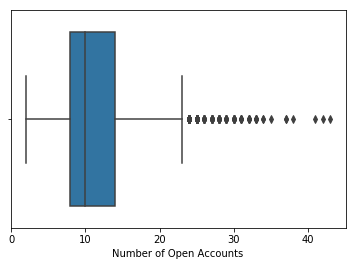

In [18]:
sns.boxplot(df['Number of Open Accounts'])

In [19]:
df.loc[df['Number of Open Accounts'] > 25, 'Number of Open Accounts'] = df["Number of Open Accounts"].mode()[0]

### Анализ данных

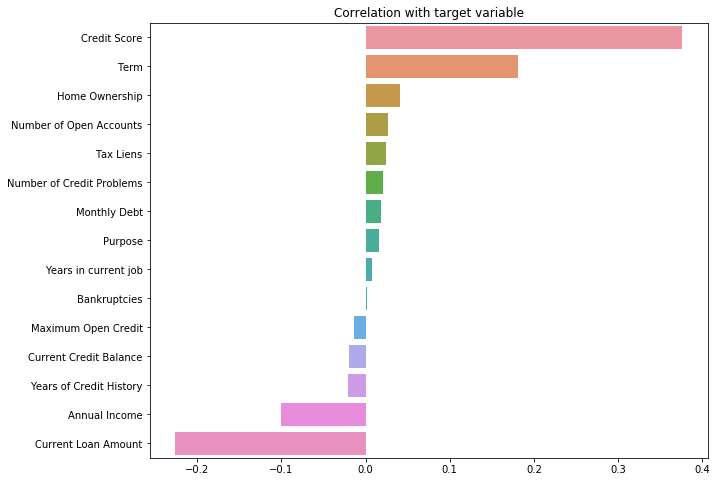

In [20]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

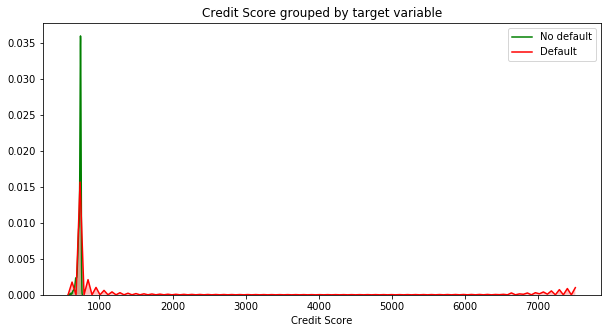

In [21]:
credit_score_with_target_s = df[['Credit Score', TARGET_NAME]].sample(1000)
credit_score_s = credit_score_with_target_s['Credit Score']
credit_score_target_0 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 0]
credit_score_target_1 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10,5))

sns.kdeplot(credit_score_target_0, shade=True, label='No default', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

### Отбор признаков

In [22]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                    'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
                    'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term']


### Подготовка признаков

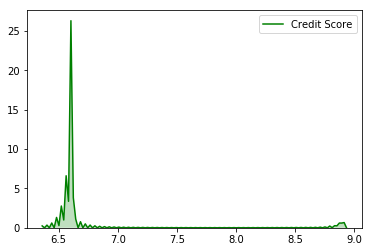

In [23]:
log_credit_score = np.log(df['Credit Score'])
sns.kdeplot(log_credit_score, shade=True, color='g')
df['Credit Score'] = log_credit_score

In [24]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership    category
Purpose           category
Term              category
dtype: object

In [25]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [26]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка таргетного класса

In [27]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)

(array([3771.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2958.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

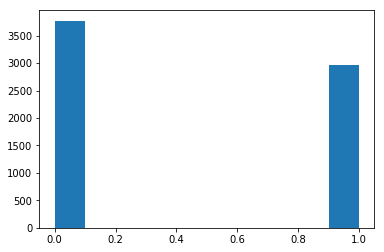

In [28]:
plt.hist(df_balanced[TARGET_NAME])

In [29]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Подбор моделей

In [30]:
# model_lr = LogisticRegression()
# model_lr.fit(X_train, y_train)

# y_train_pred = model_lr.predict(X_train)
# y_test_pred = model_lr.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [31]:
# model_knn = KNeighborsClassifier()
# model_knn.fit(X_train, y_train)

# y_train_pred = model_knn.predict(X_train)
# y_test_pred = model_knn.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [32]:
# model_lgbm = lgbm.LGBMClassifier(random_state=21)
# model_lgbm.fit(X_train, y_train)

# y_train_pred = model_lgbm.predict(X_train)
# y_test_pred = model_lgbm.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [33]:
# model_catb = catb.CatBoostClassifier(silent=True, random_state=21, cat_features=CAT_FEATURE_NAMES)
# model_catb.fit(X_train, y_train)

# y_train_pred = model_catb.predict(X_train)
# y_test_pred = model_catb.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

###  Настройка гиперпараметров

In [34]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21, cat_features=CAT_FEATURE_NAMES)
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [35]:
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)
print(rs.best_params_)
print(rs.best_score_)

{'n_estimators': 700, 'max_depth': 5}
0.5426240321511613


### Обучение и оценка финальной модели

In [36]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21,
                                      cat_features=CAT_FEATURE_NAMES, l2_leaf_reg=1)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      3771
           1       0.78      0.60      0.68      2958

   micro avg       0.75      0.75      0.75      6729
   macro avg       0.76      0.73      0.74      6729
weighted avg       0.75      0.75      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1616
           1       0.54      0.50      0.52       634

   micro avg       0.74      0.74      0.74      2250
   macro avg       0.67      0.66      0.67      2250
weighted avg       0.73      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1348  268
1                320  314


### Выбор порога вероятности для определения класса

In [37]:
y_test_pred_probs = final_model.predict_proba(X_test)

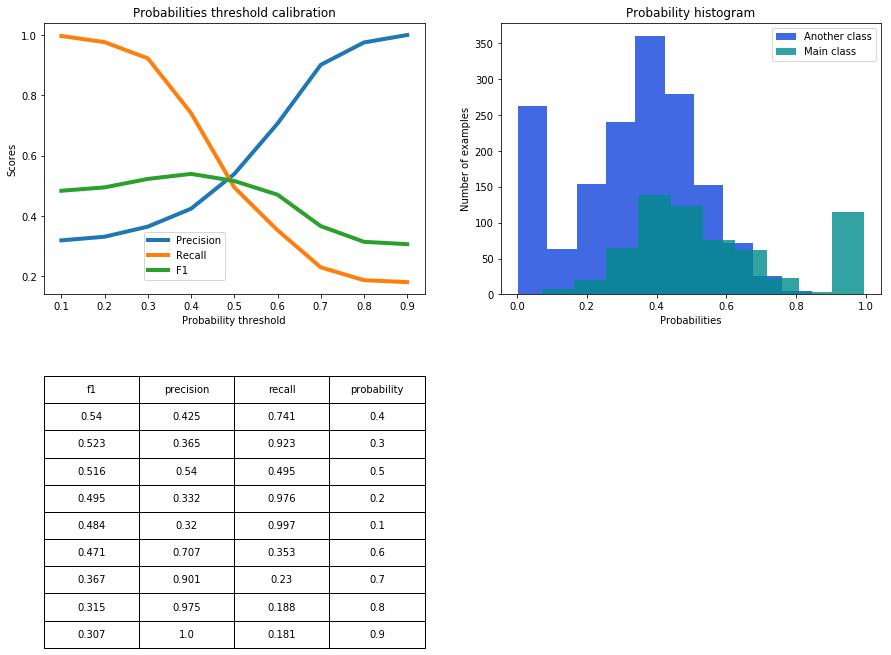

In [38]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [51]:
y_p = np.array(y_test_pred_probs[:,1] > 0.48).astype('int')
get_classification_report(y_train, y_train_pred, y_test, y_p)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      3771
           1       0.78      0.60      0.68      2958

   micro avg       0.75      0.75      0.75      6729
   macro avg       0.76      0.73      0.74      6729
weighted avg       0.75      0.75      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1616
           1       0.52      0.53      0.52       634

   micro avg       0.73      0.73      0.73      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1303  313
1                297  337


## Прогнозирование на тестовом датасете

### Подготовка данных

In [40]:
df_test = objects_to_num(df_test)
df_test = df_test.drop('Months since last delinquent',1)
df_test = fix_nans(df_test, ['Credit Score', 'Annual Income', 'Years in current job', 'Bankruptcies'])
df_test.loc[df_test['Number of Open Accounts'] > 25, 'Number of Open Accounts'] = df_test["Number of Open Accounts"].mode()[0]

log_test_credit_score = np.log(df_test['Credit Score'])
df_test['Credit Score'] = log_test_credit_score

for colname in CAT_FEATURE_NAMES:
    df_test[colname] = pd.Categorical(df_test[colname])
    
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
Home Ownership               2500 non-null category
Annual Income                2500 non-null float64
Years in current job         2500 non-null float64
Tax Liens                    2500 non-null float64
Number of Open Accounts      2500 non-null float64
Years of Credit History      2500 non-null float64
Maximum Open Credit          2500 non-null float64
Number of Credit Problems    2500 non-null float64
Bankruptcies                 2500 non-null float64
Purpose                      2500 non-null category
Term                         2500 non-null category
Current Loan Amount          2500 non-null float64
Current Credit Balance       2500 non-null float64
Monthly Debt                 2500 non-null float64
Credit Score                 2500 non-null float64
dtypes: category(3), float64(12)
memory usage: 242.8 KB


In [41]:
df_test_norm = df_test.copy()
df_test_norm[NUM_FEATURE_NAMES] = scaler.transform(df_test_norm[NUM_FEATURE_NAMES])

df_test = df_test_norm.copy()

In [42]:
X = df_test[BASE_FEATURE_NAMES]

### Прогноз целевой переменной

In [43]:
Y_pred = final_model.predict(X)
Y_pred_probs = final_model.predict_proba(X)

In [44]:
# использования порога вероятности для улучшения результата
Y_P = np.array(Y_pred_probs[:,1] > 0.49).astype('int')

In [45]:
pd.Series(Y_P).to_csv('KolchedantsevA_predictions.csv', index=False)